In [2]:
import pandas as pd
df =  pd.read_csv("data/world_cup/results.csv") #games between national teams
df["date"] = pd.to_datetime(df["date"])
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True) #games at the 2022 wc cycle
df_wc = df #pre-wc outcomes

rank = pd.read_csv("data/world_cup/fifa_ranking-2022-10-06.csv") #rankings
rank["rank_date"] = pd.to_datetime(rank["rank_date"]) 
rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True) #selecting games from the 2022 wc cycle
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States") #ajustando nomes de algumas seleções
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()
rank_wc = rank #dataframe with rankings

#Making the merge
df_wc_ranked = df_wc.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)
df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [3]:
from IPython.display import display
display(rank_wc)

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
0,2018-08-16,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
1,2018-08-17,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
2,2018-08-18,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
3,2018-08-19,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
4,2018-08-20,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
...,...,...,...,...,...,...,...,...
318894,2022-10-02,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF
318895,2022-10-03,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF
318896,2022-10-04,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF
318897,2022-10-05,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF


In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression


def calc_team_features(df_wc_ranked, team):

    df_team = df_wc_ranked.copy(deep=True)
    df_team = df_team[(df_team["home_team"] == team) | (df_team["away_team"] == team)].sort_values(by="date", ascending=False)
    df_team[f"{team}_points"] = df_team.apply(lambda x: x.total_points_home if x.home_team==team else x.total_points_away,axis=1)
    df_team[f"opponent_points"] = df_team.apply(lambda x: x.total_points_home if x.home_team!=team else x.total_points_away,axis=1)
    df_team[f"{team}_goals"] = df_team.apply(lambda x: x.home_score if x.home_team==team else x.away_score,axis=1)
    df_team["opponent_goals"] = df_team.apply(lambda x: x.home_score if x.home_team!=team else x.away_score,axis=1)
    df_team[f"{team}_rank"] = df_team.apply(lambda x: x.rank_home if x.home_team==team else x.rank_away,axis=1)
    df_team["opponent_rank"] = df_team.apply(lambda x: x.rank_home if x.home_team!=team else x.rank_away,axis=1)
    df_team[f"{team}_win"] = df_team.apply(lambda x: 2 if x[f"{team}_goals"] > x.opponent_goals else 0, axis=1)
    df_team[f"{team}_win"] = df_team.apply(lambda x: 1 if x[f"{team}_goals"] == x.opponent_goals else x[f"{team}_win"], axis=1)

    return df_team


def fit_lr_from_team_df(team_df, team):
    X = team_df[[f"{team}_points", f"{team}_rank", "opponent_points", "opponent_rank"]]
    y = team_df[f"{team}_win"]
    clf = LogisticRegression(random_state=0, multi_class="multinomial", max_iter=1000).fit(X.values, y.values)
    return clf, X.columns

def predict_matchup_probs(team_a, team_b, df_wc_ranked):
    team_a_df = calc_team_features(df_wc_ranked, team_a)
    team_b_df = calc_team_features(df_wc_ranked, team_b)
    model_a, columns_a = fit_lr_from_team_df(team_a_df, team_a)
    model_b, columns_b = fit_lr_from_team_df(team_b_df, team_b)

    team_a_features = team_a_df.sort_values(by="date").iloc[0][columns_a]
    team_b_features = team_b_df.sort_values(by="date").iloc[0][columns_b]

    team_a_features["opponent_rank"] = team_b_features[f"{team_b}_rank"]
    team_a_features["opponent_points"] = team_b_features[f"{team_b}_points"]

    team_b_features["opponent_rank"] = team_a_features[f"{team_a}_rank"]
    team_b_features["opponent_points"] = team_a_features[f"{team_a}_points"]

    team_a_predict = model_a.predict_proba(team_a_features.values.reshape(1,-1)).squeeze()
    team_b_predict = model_b.predict_proba(team_b_features.values.reshape(1,-1)).squeeze()

    # Team a lose, Team a draw, Team a win
    return np.mean([team_a_predict, team_b_predict[::-1]], axis=0)

def simulate_outcome(team_a, team_b, df_wc_ranked):

    probs = predict_matchup_probs(team_a, team_b, df_wc_ranked)

    outcome_dict = {0: "Lose", 1: "Draw", 2: "Win"}
    outcome = np.random.choice([0,1,2], p=probs)

    return outcome_dict[outcome], probs



In [5]:
simulate_outcome("Germany", "Sweden", df_wc_ranked)

('Win', array([0.10834382, 0.40716244, 0.48449374]))

In [6]:
import pickle
with open('gb_V2.pkl' , 'rb') as f:
    gb = pickle.load(f)

dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}
#TABLE -> TEAM, POINTS, WIN PROBS (CRITERIO DE DESEMPATE)
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[9].iloc[:, 1].values)]

for i in range(12, 67, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        
        matches.append((groups[group_count], team_1, team_2))
    else:
        if group_count < len(groups) - 1:
            group_count+=1
            table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

/Users/alexanderarsenault/venvs/default/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.24.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/alexanderarsenault/venvs/default/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/alexanderarsenault/venvs/default/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.24

In [12]:
from operator import itemgetter

advanced_group = []
last_group = ""
thresh = 0.05

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False

    outcome, probs = simulate_outcome(teams[1], teams[2], df_wc_ranked)

    # team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    # team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if outcome == "Draw":
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif outcome == "Win":
        winner = teams[1]
        winner_proba = probs[2]
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif outcome == "Lose":  
        winner = teams[2]
        winner_proba = probs[0]
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(probs[2])
            if i[0] == teams[2]:
                i[2].append(probs[0])

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Senegal: Winner Senegal with 0.60 probability
Group A - Netherlands vs. Ecuador: Winner Netherlands with 0.61 probability
Group A - Ecuador vs. Senegal: Winner Ecuador with 0.31 probability
Group A - Netherlands vs. Qatar: Winner Qatar with 0.16 probability


Group A advanced: 
Netherlands -------- 3
Senegal -------- 3
Ecuador -------- 3
Qatar -------- 3


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner Iran with 0.15 probability
Group B - United States vs. Wales: Winner Wales with 0.41 probability
Group B - Wales vs. Iran: Draw
Group B - England vs. United States: Winner England with 0.56 probability
Group B - Wales vs. England: Winner England with 0.64 probability
Group B - Iran vs. United States: Winner United States with 0.32 probability


Group B advanced: 
England -------- 6
Wales -------- 4
Iran -------- 4
United States -------- 3


---------- Starting Analysis for Gr

In [13]:
advanced = advanced_group
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = home
            team_2 = away

            outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)
            while outcome == "Draw":
                outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)

            team_1_prob = probs[0]
            team_2_prob = probs[2]

            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if outcome == "Lose":
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = home
            team_2 = away
            outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)
            while outcome == "Draw":
                outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)

            team_1_prob = probs[0]
            team_2_prob = probs[2]
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")

            if outcome == "Lose":
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. Wales: Netherlands advances with prob 0.32
Argentina vs. France: France advances with prob 0.06
Spain vs. Belgium: Spain advances with prob 0.33
Brazil vs. Uruguay: Brazil advances with prob 0.30
Senegal vs. England: England advances with prob 0.42
Saudi Arabia vs. Denmark: Denmark advances with prob 0.16
Japan vs. Morocco: Japan advances with prob 0.29
Switzerland vs. South Korea: South Korea advances with prob 0.34
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. France: Netherlands advances with prob 0.37
Spain vs. Brazil: Brazil advances with prob 0.39
England vs. Denmark: Denmark advances with prob 0.52
Japan vs. South Korea: Japan advances with prob 0.29
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Brazil: Brazil advances with prob 0.24
Denmark vs. Japan: Denmark advances with prob 0.44
----------
Starting simulation of Final
----------


Brazil vs. 

In [19]:
# Total sim
from operator import itemgetter
from tqdm import tqdm
verbose = False
wc_winners = []

for sim in tqdm(range(500)):
    advanced_group = []
    last_group = ""
    thresh = 0.05

    for k in table.keys():
        for t in table[k]:
            t[1] = 0
            t[2] = []
        
    for teams in matches:
        draw = False

        outcome, probs = simulate_outcome(teams[1], teams[2], df_wc_ranked)
        
        if outcome == "Draw":
            draw=True
            for i in table[teams[0]]:
                if i[0] == teams[1] or i[0] == teams[2]:
                    i[1] += 1
                    
        elif outcome == "Win":
            winner = teams[1]
            winner_proba = probs[2]
            for i in table[teams[0]]:
                if i[0] == teams[1]:
                    i[1] += 3
                    
        elif outcome == "Lose":  
            winner = teams[2]
            winner_proba = probs[0]
            for i in table[teams[0]]:
                if i[0] == teams[2]:
                    i[1] += 3
        
        for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
                if i[0] == teams[1]:
                    i[2].append(probs[2])
                if i[0] == teams[2]:
                    i[2].append(probs[0])

        if last_group != teams[0]:
            if last_group != "":
                if verbose == True:
                    print("\n")
                    print("Group %s advanced: "%(last_group))
                
                for i in table[last_group]: #adding crieterio de desempate
                    i[2] = np.mean(i[2])
                
                final_points = table[last_group]
                final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
                advanced_group.append([final_table[0][0], final_table[1][0]])
                for i in final_table:
                    if verbose == True:
                        print("%s -------- %d"%(i[0], i[1]))
            if verbose == True:
                print("\n")
                print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
            
        if verbose == True:
            if draw == False:
                print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
            else:
                print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
        last_group =  teams[0]

    if verbose == True:
        print("\n")
        print("Group %s advanced: "%(last_group))

    for i in table[last_group]: #adding crieterio de desempate
        i[2] = np.mean(i[2])
                
    final_points = table[last_group]
    final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
    advanced_group.append([final_table[0][0], final_table[1][0]])
    for i in final_table:
        if verbose == True:
            print("%s -------- %d"%(i[0], i[1]))

    advanced = advanced_group
    playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

    for p in playoffs.keys():
        playoffs[p] = []

    actual_round = ""
    next_rounds = []

    for p in playoffs.keys():
        if p == "Round of 16":
            control = []
            for a in range(0, len(advanced*2), 1):
                if a < len(advanced):
                    if a % 2 == 0:
                        control.append((advanced*2)[a][0])
                    else:
                        control.append((advanced*2)[a][1])
                else:
                    if a % 2 == 0:
                        control.append((advanced*2)[a][1])
                    else:
                        control.append((advanced*2)[a][0])

            playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
            
            for i in range(0, len(playoffs[p]), 1):
                game = playoffs[p][i]
                
                home = game[0]
                away = game[1]
                team_1 = home
                team_2 = away

                outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)
                while outcome == "Draw":
                    outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)

                team_1_prob = probs[0]
                team_2_prob = probs[2]

                if actual_round != p:
                    if verbose == True:
                        print("-"*10)
                        print("Starting simulation of %s"%(p))
                        print("-"*10)
                        print("\n")
                
                if outcome == "Lose":
                    if verbose == True:
                        print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                    next_rounds.append(away)
                else:
                    if verbose == True:
                        print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                    next_rounds.append(home)
                
                game.append([team_1_prob, team_2_prob])
                playoffs[p][i] = game
                actual_round = p
            
        else:
            playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
            next_rounds = []
            for i in range(0, len(playoffs[p])):
                game = playoffs[p][i]
                home = game[0]
                away = game[1]
                team_1 = home
                team_2 = away
                outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)
                while outcome == "Draw":
                    outcome, probs = simulate_outcome(team_1, team_2, df_wc_ranked)

                team_1_prob = probs[0]
                team_2_prob = probs[2]
                
                if actual_round != p:
                    if verbose == True:
                        print("-"*10)
                        print("Starting simulation of %s"%(p))
                        print("-"*10)
                        print("\n")

                if outcome == "Lose":
                    if verbose == True:
                        print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                    next_rounds.append(away)
                else:
                    if verbose == True:
                        print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                    next_rounds.append(home)
                
                game.append([team_1_prob, team_2_prob])
                playoffs[p][i] = game
                actual_round = p

                if (p=="Final"):
                    wc_winners.append(next_rounds[0])

100%|██████████| 500/500 [12:27<00:00,  1.49s/it]


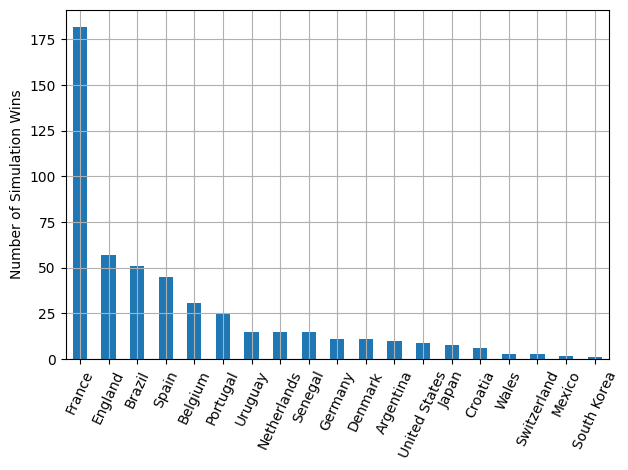

In [27]:
from matplotlib import pyplot as plt
wc_winner_df = pd.DataFrame(wc_winners, columns=["wc_winners"])
wc_winner_df["wc_winners"].value_counts().plot.bar()
plt.grid()
plt.ylabel("Number of Simulation Wins")
plt.xticks(rotation=65)
plt.tight_layout()

In [29]:
wc_winner_df.value_counts()/500

wc_winners   
France           0.364
England          0.114
Brazil           0.102
Spain            0.090
Belgium          0.062
Portugal         0.050
Netherlands      0.030
Senegal          0.030
Uruguay          0.030
Denmark          0.022
Germany          0.022
Argentina        0.020
United States    0.018
Japan            0.016
Croatia          0.012
Wales            0.006
Switzerland      0.006
Mexico           0.004
South Korea      0.002
dtype: float64